In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)
from tqdm import tqdm
import datetime
from itertools import combinations
from collections import Counter
import itertools
import re

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.metrics import precision_score , recall_score , f1_score
from scipy import stats
from scipy.spatial.distance import mahalanobis

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import *
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam

In [3]:
data_train = pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_Train.csv')
data_test =  pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_Test.csv')
data_sub =   pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_SubmissionFormat.csv')

In [4]:
data_train = data_train.drop(['Unique_ID','MORTGAGE NUMBER'],axis=1)
data_test =  data_test.drop(['Unique_ID','MORTGAGE NUMBER','RESULT'], axis=1)

In [5]:
#Train data separating the response
y       = data_train['RESULT']
x_train = data_train.drop(['RESULT'],axis=1)


In [6]:
#Test data and train data merged for pre-processing
x_comb = pd.concat([x_train,data_test],sort=False)

In [7]:
cont_cols = ['PROPERTY VALUE','MORTGAGE PAYMENT','GDS','LTV','TDS','AMORTIZATION','MORTGAGE AMOUNT',
             'INCOME','CREDIT SCORE','RATE']

In [8]:
cat_cols = ['PAYMENT FREQUENCY','PROPERTY TYPE','FSA','TERM','AGE RANGE','GENDER','INCOME TYPE',
           'NAICS CODE','MORTGAGE PURPOSE']

In [10]:
log_transformed = ['PROPERTY VALUE','MORTGAGE PAYMENT','LTV','INCOME','CREDIT SCORE','MORTGAGE AMOUNT']

In [11]:
non_log_cols = ['GDS','LTV','TDS','AMORTIZATION','RATE']

In [12]:
for col in tqdm(cat_cols):
    le = LabelEncoder()
    x_comb[col] = le.fit_transform(x_comb[col])

100%|██████████| 9/9 [00:00<00:00, 17.68it/s]


In [13]:
z=[]
for col in tqdm(cat_cols):
    z.append((col,x_comb[col].unique().shape))

100%|██████████| 9/9 [00:00<00:00, 497.93it/s]


In [14]:
#Label Encoding the y-var
le_y = LabelEncoder()

y_cat = le_y.fit_transform(y)

In [15]:
x_comb.skew()

PROPERTY VALUE         5.260160
MORTGAGE PAYMENT       4.135354
GDS                  180.294731
LTV                   -1.875249
TDS                  154.046538
AMORTIZATION          -4.740900
MORTGAGE AMOUNT        3.665322
RATE                   1.145228
MORTGAGE PURPOSE       0.141211
PAYMENT FREQUENCY     -4.023413
PROPERTY TYPE         -0.406087
TERM                   2.376065
FSA                    0.569508
AGE RANGE              0.377381
GENDER                 0.192380
INCOME                 6.571547
INCOME TYPE            0.619233
NAICS CODE            -0.296763
CREDIT SCORE          -3.087467
dtype: float64

RESULT
FUNDED        [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
NOT FUNDED    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

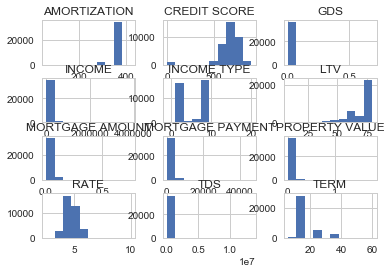

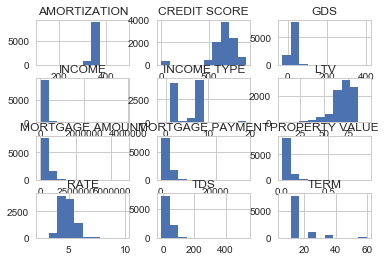

In [16]:
data_train.groupby('RESULT').hist()

In [ ]:
#plt.hist(data_train[data_train['RESULT'] == 'NOT FUNDED']['AMORTIZATION'])

In [ ]:
#plt.hist(data_train[data_train['RESULT'] == 'FUNDED']['AMORTIZATION'])

In [31]:
for col in log_transformed:
    x_comb[col] = np.log1p(x_comb[col])
    

In [32]:
cont_cols = cont_cols + log_transformed

In [33]:
col_count = []

for col in tqdm(cont_cols):
    counter = Counter(x_comb[col])
    col_count.append(str(col)+'count')
    x_comb[str(col)+'count'] = x_comb[col].apply(lambda x:counter[x])

100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


In [34]:
aggs = {}

aggs['MORTGAGE PAYMENT'] = ['median', 'mean','std']
aggs['GDS'] = ['median', 'mean','std']
aggs['LTV'] = ['median', 'mean','std']
aggs['TDS'] = ['median', 'mean','std']
aggs['AMORTIZATION'] = ['median', 'mean','std']
aggs['INCOME'] = ['median', 'mean','std']
aggs['CREDIT SCORE'] = ['median', 'mean','std']
aggs['MORTGAGE AMOUNT'] = ['median', 'mean','std']
aggs['PROPERTY VALUE'] = ['median', 'mean','std']
aggs['RATE'] = ['median', 'mean','std']
aggs['PAYMENT FREQUENCY'] = ['count','mean','median']
aggs['PROPERTY TYPE'] = ['count','mean','median']
aggs['FSA'] = ['count','mean','median']
aggs['TERM'] = ['count','mean','median']
aggs['AGE RANGE'] = ['count','mean','median']
aggs['GENDER'] = ['count','mean','median']
aggs['INCOME TYPE'] = ['count','mean','median']
aggs['NAICS CODE'] = ['count','mean','median']
aggs['MORTGAGE PURPOSE'] = ['count','mean','median']


for col in tqdm(cat_cols):
    agg_df = x_comb.groupby(col).agg(aggs).reset_index()
    agg_df.columns = [col] + [col + '_' + c[0] +'_' + c[1] for c in agg_df.columns[1:]]
    x_comb = pd.merge(x_comb, agg_df, on=col, how="left")

100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


In [35]:
#Continuous-continuous features
list_cont_cont = list(combinations(cont_cols,2))

for cols in tqdm(list_cont_cont):
    col1 = cols[0]
    col2 = cols[1]
    x_comb[col1+col2+'sum'] =  x_comb[col1]+x_comb[col2]
    x_comb[col1+col2+'mult'] = x_comb[col1]*x_comb[col2]
    x_comb[col1+col2+'div1'] = x_comb[col1]/x_comb[col2]
    x_comb[col1+col2+'div2'] = x_comb[col2]/x_comb[col1]
    x_comb[col1+col2+'sub'] =  x_comb[col1] - x_comb[col2]

100%|██████████| 120/120 [00:04<00:00, 29.07it/s]


In [36]:
#Categorical-Categorical features
list_cat_cat = list(combinations(cat_cols,2))

for cols in tqdm(list_cat_cat):
    col1 = cols[0]
    col2 = cols[1]
    x_comb['cat'+col1+col2+'mult'] = x_comb[col1]*x_comb[col2]
            

100%|██████████| 105/105 [00:01<00:00, 85.66it/s]


In [38]:
#Categorical-Categorical features
list_cat_cat2 = list(combinations(cat_cols,3))

for cols in tqdm(list_cat_cat2):
    col1 = cols[0]
    col2 = cols[1]
    col3 = cols[2]
    x_comb['cat3'+col1+col2+col3+'mult'] = x_comb[col1]*x_comb[col2]*x_comb[col3]
            

100%|██████████| 455/455 [00:02<00:00, 168.10it/s]


In [39]:
#Categorical-Categorical features
list_cont_cont2 = list(combinations(cont_cols,3))

for cols in tqdm(list_cont_cont2):
    col1 = cols[0]
    col2 = cols[1]
    col3 = cols[2]
    x_comb['cont3'+col1+col2+col3+'mult'] = x_comb[col1]*x_comb[col2]*x_comb[col3]
            

100%|██████████| 560/560 [00:06<00:00, 89.84it/s]


In [40]:
#Categorical-continuous
list_cat_cont = list(itertools.product(cat_cols, cont_cols))

for cols in tqdm(list_cat_cont):
    col1 = cols[0]
    col2 = cols[1]
    x_comb['cat_cont'+col1+col2+'mult'] = x_comb[col1]*x_comb[col2]

100%|██████████| 240/240 [00:02<00:00, 119.56it/s]


In [43]:
train_x = x_comb[0:45642]
test_x =  x_comb[45642:]

In [49]:
y_ker = to_categorical(y_cat)

In [50]:
x1_train, x1_val, y1_train, y1_val = train_test_split(train_x, y_ker,test_size=0.2,random_state=0,
                                                      stratify = y)
                                                      

In [46]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [59]:
def model_deep():
    
    #Defining the input-----> Transaction
    inputs = Input(shape=(2438,))
    layer_dense = Dense(500, activation='relu')(inputs)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(100, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(50, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(40, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(30, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(20, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(10, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    layer_dense = Dense(5, activation='relu')(layer_dense)
    layer_dense = Dropout(0.5)(layer_dense)
    
    probabilities = Dense(2,activation='softmax')(layer_dense)
    
    model = Model(inputs=inputs,outputs=probabilities)
    return model

In [60]:
model1 = model_deep()

In [61]:
model1.compile(loss = "categorical_crossentropy", 
              optimizer = Adam(lr=0.01), 
              metrics = [f1])

In [63]:
# history = model1.fit(train_x,
#                      y_ker,
#                      batch_size = 256, 
#                      epochs = 10, 
#                      class_weight = {0:2,1:0.8},
#                      validation_split=0.16,
#                      verbose = 1)

In [58]:
train_x.shape

(45642, 2438)

In [ ]:
### funded : 0,  not funded 1
best_thresh = None
val_score = 0

for thresh in np.linspace(start = 0.4, stop = 0.8, num = 40):
    
    val_preds = lgb_clf.predict(x1_val, num_iteration = lgb_clf.best_iteration)
    ans = [1 if (val > thresh) else 0 for val in val_preds]
    
    score = f1_score(y1_val, ans, average='macro')
    print("Thresh", thresh, "F1 score:", score)
    
    if score > val_score:
        val_score = score
        best_thresh = thresh

        
print("\nThresh", best_thresh, "F1 score:", val_score)


In [ ]:
#('\nThresh', 0.5948717948717949, 'F1 score:', 0.6749024684341038)

In [ ]:
pred = lgb_clf.predict(test_x)

In [ ]:
y_pred = ['NOT FUNDED' if x >= 0.5538 else 'FUNDED' for x in pred]

In [ ]:
print (y_pred.count('NOT FUNDED'))
print (y_pred.count('FUNDED'))

In [ ]:
data_sub['Result_Predicted'] = y_pred

In [ ]:
data_sub.to_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/Submission_new5.csv',index=False)

Error Analysis

In [ ]:
pred_val  = lgb_clf.predict(x1_val)

In [ ]:
err = (y1_val - pred_val)**2

In [ ]:
plt.scatter(x1_val['AMORTIZATION'],err)

In [ ]:
list(x1_val.columns)